# Phytoplankton biomass
<div>
<img src="https://img.pagecloud.com/nXOUkUjhhkla7tj6dosu06sE0-I=/1398x0/filters:no_upscale()/scientific-illustrations-by-kristen/images/cocco_in_blue_v2-lc467.png" width="500"/>
</div>

A coccolithophore, a type of phytoplankton. Art credit: [Kristen Krumhardt](https://kristenkrumhardtart.com/)

---

## Overview
Phytoplankton are single-celled, photosynthesizing organisms found throughout the global ocean. Though there are many different species of phytoplankton, CESM-MARBL groups them into four categories called functional types: small phytoplankton, diatoms (which build silica-based shells), coccolithophores (which build calcium carbonate-based shells), and diazotrophs (which fix nitrogen). In this notebook, we evaluate the biomass and total production of these phytoplankton in different areas, as modeled by CESM-MARBL.

1. General setup
2. Subsetting
3. Taking a quick look
4. Processing - long-term mean
5. Mapping biomass at different depths
6. Mapping productivity
7. Compare NPP to satellite observations
   

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy) | Necessary | |
| [Dask Cookbook](https://projectpythia.org/dask-cookbook) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray) | Helpful | |

- **Time to learn**: 30 min


---

## Imports

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster
import s3fs
from datetime import datetime

from module import adjust_pop_grid

/free1/ktyle/miniforge_2025/envs/ocean-bgc-cookbook-dev/lib/python3.13/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()

### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

### Load the data

In [4]:
jetstream_url = 'https://js2.jetstream-cloud.org:8001/'

s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(endpoint_url=jetstream_url))

# Generate a list of all files in CESM folder
s3path = 's3://pythia/ocean-bgc/cesm/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1/*'
remote_files = s3.glob(s3path)
s3.invalidate_cache()

# Open all files from folder
fileset = [s3.open(file) for file in remote_files]

# Open with xarray
ds = xr.open_mfdataset(fileset, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)

ds

<xarray.Dataset> Size: 28GB
Dimensions:                         (time: 120, nlat: 384, nlon: 320, z_t: 60,
                                     z_t_150m: 15)
Coordinates:
    TLAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                            (time) object 960B 2010-01-16 12:00:00 .....
  * z_t                             (z_t) float32 240B 500.0 ... 5.375e+05
  * z_t_150m                        (z_t_150m) float32 60B 500.0 ... 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables: (12/45)
    FG_CO2                          (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    Fe                              (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    NO3                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    PO4                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    POC_FLUX_100m                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    SALT                            (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    ...                              ...
    sp_Fe_lim_Cweight_avg_100m      (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_Fe_lim_surf                  (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>

## Subsetting

In [5]:
variables =['diatC', 'coccoC','spC','diazC',
            'photoC_TOT_zint',
            'photoC_sp_zint','photoC_diat_zint',
            'photoC_diaz_zint','photoC_cocco_zint']
keep_vars=['z_t','z_t_150m','dz','time_bound', 'time', 'TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

## Taking a quick look

Let's plot the biomass of coccolithophores as a first look. These plots show snapshots six months apart - note the difference between seasons! Also take a look at the increased concentrations of coccolithophores in the Southern Ocean during Southern-hemisphere summer; the increased concentrations of calcite caused by these plankton building calcite shells leads to this region being known as the [Great Calcite Belt](https://en.wikipedia.org/wiki/Great_Calcite_Belt).

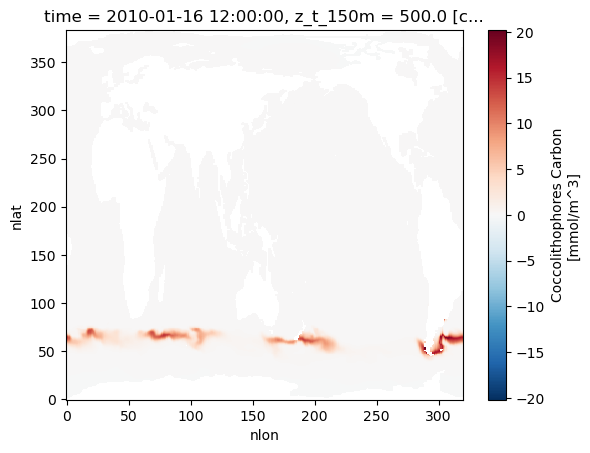

In [6]:
ds.coccoC.isel(time=0,z_t_150m=0).plot()

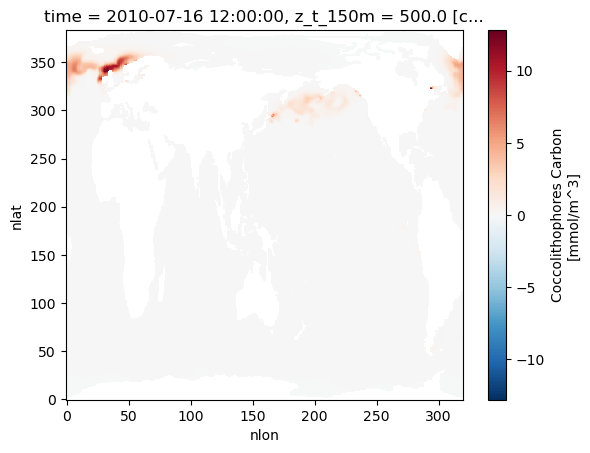

In [7]:
ds.coccoC.isel(time=6,z_t_150m=0).plot()

## Processing - long-term mean

Pull in the function we defined in the nutrients notebook...

In [8]:
def year_mean(ds):
    """
    Properly convert monthly data to annual means, taking into account month lengths.
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.year'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the year for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")
    

Take the long-term mean of our data set. We process monthly to annual with our custom function, then use xarray's built-in `.mean()` function to process from annual data to a single mean over time, since each year is the same length.

In [9]:
ds_ann = year_mean(ds)

In [10]:
ds = ds_ann.mean("year")

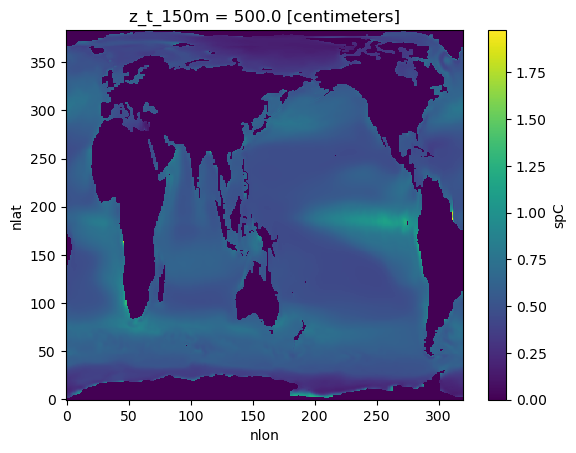

In [11]:
ds['spC'].isel(z_t_150m=0).plot()

## Mapping biomass at different depths
Note the different colorbar scales on each of these maps!
### Phytoplankton biomass at the surface

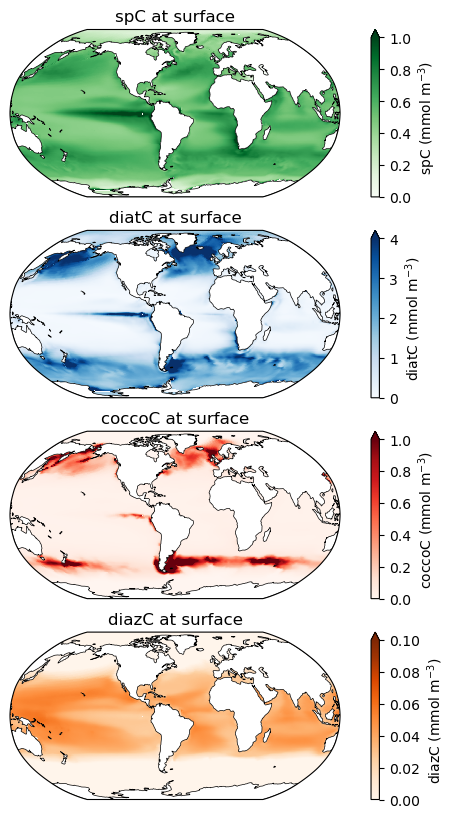

In [12]:
###### 
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
# spC stands for "small phytoplankton carbon"
ax.set_title('spC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.spC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='Greens',vmin=0,vmax=1,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)


ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
# diatC stands for "diatom carbon"
ax.set_title('diatC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diatC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='Blues',vmin=0,vmax=4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)


ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
# coccoC stands for "coccolithophore carbon"
ax.set_title('coccoC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.coccoC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=1,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
# diazC stands for "diazotroph carbon"
ax.set_title('diazC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diazC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='Oranges',vmin=0,vmax=0.1,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

### Phytoplankton biomass at 100m

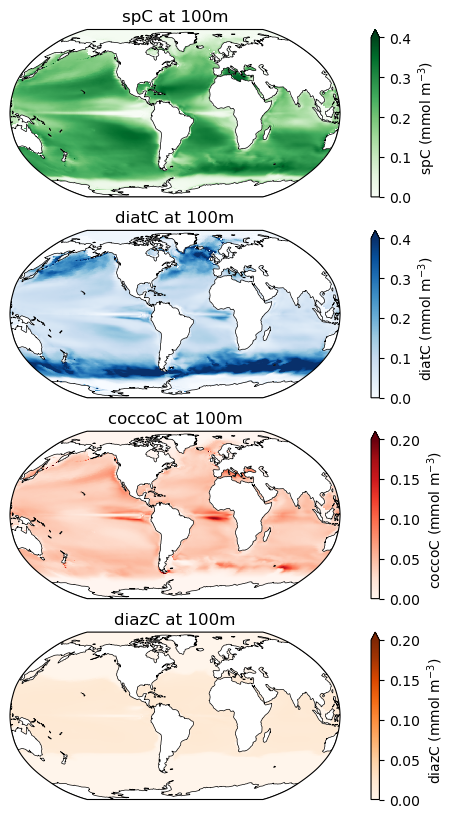

In [13]:
###### 
fig = plt.figure(figsize=(8,10))


ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.spC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='Greens',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diatC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='Blues',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.coccoC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diazC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='Oranges',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

## Mapping productivity

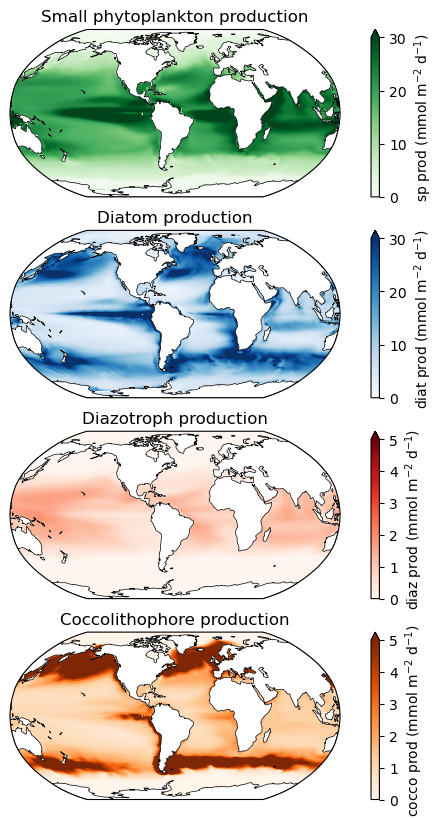

In [14]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds.photoC_sp_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='Greens',vmin=0,vmax=30,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds.photoC_diat_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='Blues',vmin=0,vmax=30,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds.photoC_diaz_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Coccolithophore production', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds.photoC_cocco_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='Oranges',vmin=0,vmax=5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco prod (mmol m$^{-2}$ d$^{-1}$)');

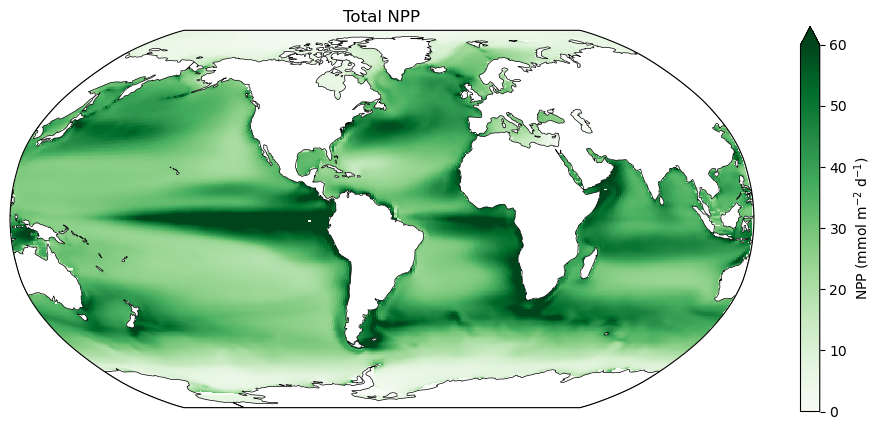

In [15]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Total NPP', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.photoC_TOT_zint*864.)
pc=ax.pcolormesh(lon, lat, field, cmap='Greens',vmin=0,vmax=60,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol m$^{-2}$ d$^{-1}$)');

### Globally integrated NPP

In [16]:
def global_mean(ds, ds_grid, compute_vars, normalize=True, include_ms=False):
    """
    Compute the global mean on a POP dataset. 
    Return computed quantity in conventional units.
    """

    other_vars = list(set(ds.variables) - set(compute_vars))

    # note TAREA is in cm^2, which affects units

    if include_ms: # marginal seas!
        surface_mask = ds_grid.TAREA.where(ds_grid.KMT > 0).fillna(0.)
    else:
        surface_mask = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.)        
    
    masked_area = {
        v: surface_mask.where(ds[v].notnull()).fillna(0.) 
        for v in compute_vars
    }
    
    with xr.set_options(keep_attrs=True):
        
        dso = xr.Dataset({
            v: (ds[v] * masked_area[v]).sum(['nlat', 'nlon'])
            for v in compute_vars
        })
        
        if normalize:
            dso = xr.Dataset({
                v: dso[v] / masked_area[v].sum(['nlat', 'nlon'])
                for v in compute_vars
            })            
                
    return dso

In [17]:
ds_glb = global_mean(ds, ds_grid, variables,normalize=False).compute()

# convert from nmol C/s to Pg C/yr
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

for v in variables:
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'
    
ds_glb

<xarray.Dataset> Size: 580B
Dimensions:            (z_t_150m: 15)
Coordinates:
  * z_t_150m           (z_t_150m) float32 60B 500.0 1.5e+03 ... 1.45e+04
Data variables:
    diatC              (z_t_150m) float64 120B 1.474e+03 1.411e+03 ... 27.73
    coccoC             (z_t_150m) float64 120B 163.5 160.3 150.0 ... 7.543 5.085
    spC                (z_t_150m) float64 120B 763.9 747.5 708.3 ... 60.17 42.67
    diazC              (z_t_150m) float64 120B 35.42 35.27 ... 0.2501 -0.07041
    photoC_TOT_zint    float64 8B 53.26
    photoC_sp_zint     float64 8B 27.72
    photoC_diat_zint   float64 8B 21.14
    photoC_diaz_zint   float64 8B 1.003
    photoC_cocco_zint  float64 8B 3.399

## Comparing to NPP satellite data

We load in a satellite-derived estimate of NPP, calculated with the VGPM algorithm [(Behrenfeld and Falkowski, 1997)](https://doi.org/10.4319/lo.1997.42.1.0001). This data can be found at [this website](http://orca.science.oregonstate.edu/1080.by.2160.monthly.hdf.vgpm.m.chl.m.sst.php); we've re-uploaded a portion of it for easier access. It was originally provided in the format of HDF4 files; we have converted these to NetCDF files to make reading in data from the cloud more straightforward, but some additional processing is still required to format the time and space coordinates correctly before we can work with the data.

In [20]:
s3path = 's3://pythia/ocean-bgc/obs/vgpm/*.nc'

remote_files = s3.glob(s3path)
s3.invalidate_cache()

# Open all files from bucket
fileset = [s3.open(file) for file in remote_files]


Let's try reading in one of these files to see what the format looks like.

In [21]:
test_ds = xr.open_dataset(fileset[0])

test_ds

<xarray.Dataset> Size: 9MB
Dimensions:      (band: 1, y: 1080, x: 2160)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 17kB 0.5 1.5 2.5 ... 2.158e+03 2.158e+03 2.16e+03
  * y            (y) float64 9kB 0.5 1.5 2.5 ... 1.078e+03 1.078e+03 1.08e+03
Data variables:
    spatial_ref  int64 8B ...
    band_data    (band, y, x) float32 9MB ...

In [22]:
all_single_ds = []

for file in fileset:
    ds_singlefile = xr.open_dataset(file)
    timestr = ds_singlefile["band_data"].attrs["Start Time String"]
    format_data = "%m/%d/%Y %H:%M:%S"
    ds_singlefile["time"] = datetime.strptime(timestr, format_data)
    all_single_ds.append(ds_singlefile)

ds_sat = xr.concat(all_single_ds, dim="time")
    

/free1/ktyle/miniforge_2025/envs/ocean-bgc-cookbook-dev/lib/python3.13/site-packages/xarray/structure/concat.py:547: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [23]:
ds_sat

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 120, band: 1, y: 1080, x: 2160)
Coordinates:
  * time         (time) datetime64[ns] 960B 2010-01-01 2010-02-01 ... 2019-12-01
  * band         (band) int64 8B 1
  * x            (x) float64 17kB 0.5 1.5 2.5 ... 2.158e+03 2.158e+03 2.16e+03
  * y            (y) float64 9kB 0.5 1.5 2.5 ... 1.078e+03 1.078e+03 1.08e+03
Data variables:
    spatial_ref  (time) int64 960B 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    band_data    (time, band, y, x) float32 1GB -9.999e+03 ... -9.999e+03

Now we have a time dimension! Let's try plotting the data to see what else we need to fix.

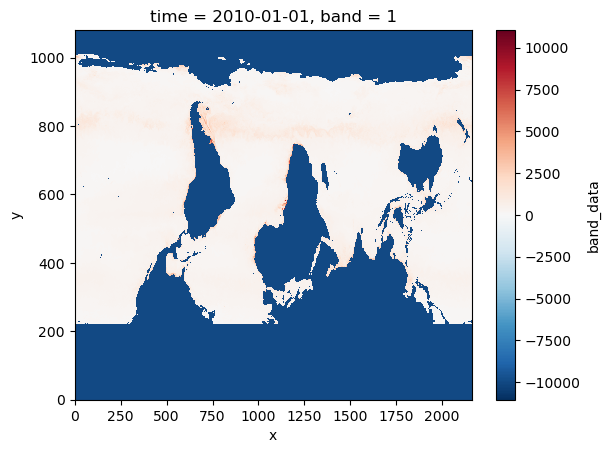

In [24]:
ds_sat.band_data.isel(time=0, band=0).plot()

There are a few things going on here. The data is upside down from a more common map projection, and the spatial coordinates are a generic x and y rather than latitude and longitude. The color scale also doesn't look right because areas like land that should be masked out are showing up as a low negative value, throwing off the positive values we actually want to see. We also have an extra `band` coordinate in the dataset - probably a holdover from the satellite data this product was generated from, but no longer giving us useful information. In the next block, we fix these problems.

### Preliminary processing

In [25]:
# fix coords
ds_sat = ds_sat.rename(name_dict={"x": "lon", "y": "lat", "band_data": "NPP"})
ds_sat["lon"] = (ds_sat.lon/6 + 180) % 360
ds_sat = ds_sat.sortby(ds_sat.lon)
ds_sat["lat"] = (ds_sat.lat/6 - 90)[::-1]

# mask values
ds_sat = ds_sat.where(ds_sat.NPP != -9999.) 

# get rid of extra dimensions
ds_sat = ds_sat.squeeze(dim="band", drop=True)
ds_sat = ds_sat.drop_vars("spatial_ref")

# make NPP units match previous dataset
ds_sat["NPP"] = ds_sat.NPP / 12.01
ds_sat["NPP"] = ds_sat.NPP.assign_attrs(
    units="mmol m-2 day-1")


In [26]:
ds_sat

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 120, lat: 1080, lon: 2160)
Coordinates:
  * time     (time) datetime64[ns] 960B 2010-01-01 2010-02-01 ... 2019-12-01
  * lon      (lon) float64 17kB 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * lat      (lat) float64 9kB 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
Data variables:
    NPP      (time, lat, lon) float32 1GB nan nan nan nan ... nan nan nan nan

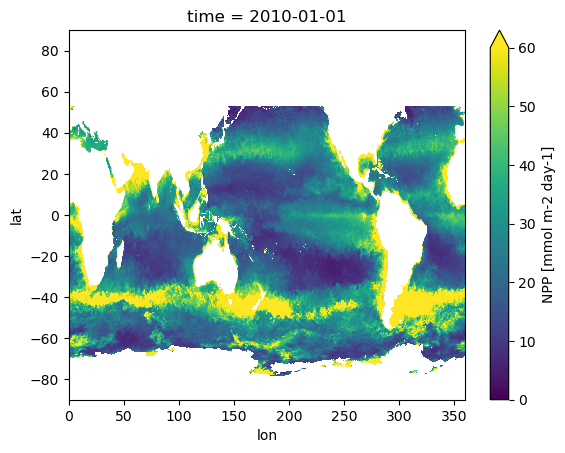

In [27]:
ds_sat.NPP.isel(time=0).plot(vmin=0, vmax=60)

In [28]:
ds_sat

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 120, lat: 1080, lon: 2160)
Coordinates:
  * time     (time) datetime64[ns] 960B 2010-01-01 2010-02-01 ... 2019-12-01
  * lon      (lon) float64 17kB 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * lat      (lat) float64 9kB 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
Data variables:
    NPP      (time, lat, lon) float32 1GB nan nan nan nan ... nan nan nan nan

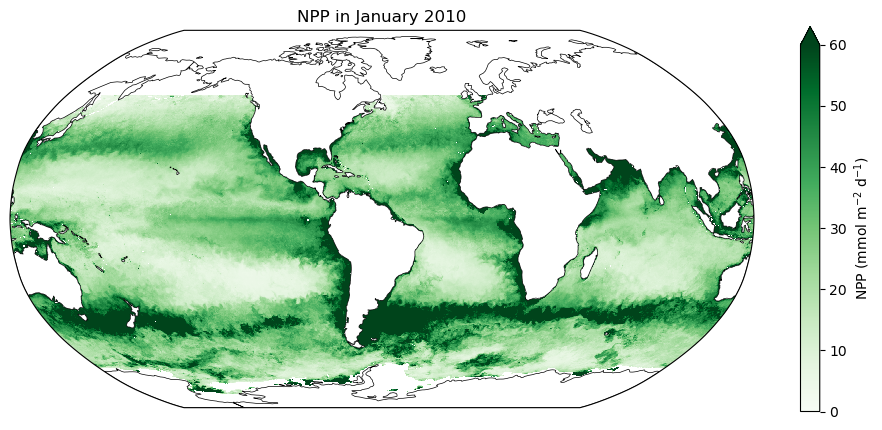

In [29]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP in January 2010', fontsize=12)
pc=ax.pcolormesh(ds_sat.lon, ds_sat.lat, ds_sat.NPP.isel(time=0), cmap='Greens',vmin=0,vmax=60,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol m$^{-2}$ d$^{-1}$)');

### Making a comparison map

Now let's process in time. Use the monthly to annual function that we made before.

In [30]:
ds_sat_ann = year_mean(ds_sat)

In [31]:
ds_sat_timemean = ds_sat_ann.mean("year")

In [32]:
ds_sat_timemean

<xarray.Dataset> Size: 19MB
Dimensions:  (lat: 1080, lon: 2160)
Coordinates:
  * lon      (lon) float64 17kB 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * lat      (lat) float64 9kB 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
Data variables:
    NPP      (lat, lon) float64 19MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [ ]:
fig = plt.figure(figsize=(16,5))

fig.suptitle("NPP, mean over 2010-2019")

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM (Model)', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.photoC_TOT_zint*864.)
pc=ax.pcolormesh(lon, lat, field, cmap='Greens',vmin=0,vmax=60,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('VGPM (Satellite-based algorithm)', fontsize=12)
pc=ax.pcolormesh(ds_sat_timemean.lon, ds_sat_timemean.lat, ds_sat_timemean.NPP, cmap='Greens',vmin=0,vmax=60,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='NPP (mmol m$^{-2}$ d$^{-1}$)')
plt.show()



And close the Dask cluster we spun up at the beginning.

In [ ]:
cluster.close()

---

## Summary
You've learned how to take a look at a few quantities related to phytoplankton in CESM, as well as processing an observation-derived dataset in a different format.

## Resources and references
- [Sarmiento and Gruber Chapter 4: Organic Matter Production](https://doi.org/10.2307/j.ctt3fgxqx.7) (see Phytoplankton in Section 4.2)
- [Behrenfeld and Falkowski, 1997](https://doi.org/10.4319/lo.1997.42.1.0001)
- [VGPM ocean productivity data](http://orca.science.oregonstate.edu/1080.by.2160.monthly.hdf.vgpm.m.chl.m.sst.php)
